In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm import tqdm
from scipy.stats import linregress
from ipywidgets import interact, FloatSlider

import sys
from importlib import reload
sys.path.append("../scripts")
import solution_fpt as fpt

fpt = reload(fpt)

# First Passage Times

We want to get the simulated first passage time distribution

In [2]:
@njit
def init_config(N, m0):
    """Initializes configuration"""
    n_up = int(N * (1 + m0) / 2)
    
    r = np.full(N, -1, dtype=np.int8)
    r[:n_up] = 1
    return r
    

@njit
def first_passage_time(N, m0, r):
    '''Takes:
    N: number of agents
    r: resetting rate per MC step
    m0: starting magnetisation
    
        Returns:
    t/N: The first passage time to consensus'''
    
    # Initialize
    config = init_config(N, m0)
    ini = config.copy()
    
    current_sum = np.sum(config)
    ini_sum = current_sum
    
    t = 0
    
    while np.abs(current_sum) != N:
        t += 1
        
       
        if np.random.random() < (r / N):

            config[:] = ini[:] 
            current_sum = ini_sum
            continue
            
        a = np.random.randint(N)
        b = np.random.randint(N - 1)
        if b >= a:
            b += 1
            
        target_val = config[b]
        old_val = config[a]
        
        if old_val != target_val:
            config[a] = target_val
    
            current_sum += (target_val - old_val) #Only update the sum if it changes

    return t / N
    

@njit(parallel=True)
def fpt_dist(N, m0, r, samples):
    """
    Returns the first passage time for many samples
    """
    res = np.zeros(samples)
    

    for i in prange(samples):
        res[i] = first_passage_time(N, m0, r)
        
    return res

In [ ]:
fpt = fpt_dist(1000, 0, 0.1, 10000)

In [ ]:
plt.yscale("log")
plt.hist(fpt, bins = 30, density = "true")

In [3]:
def get_linreg_stats(x, y):
    """
    Returns slope, intercept, their standard errors, and R^2.
    """
    res = linregress(x, y)
    
    return {
        "slope": res.slope,
        "intercept": res.intercept,
        "slope_err": res.stderr,
        "intercept_err": res.intercept_stderr,
        "r_squared": res.rvalue**2
    }

In [41]:
y,x = np.histogram(fpt, bins = 30, density = True)
x = (x[:-1] + x[1:]) / 2
print(get_linreg_stats(x, y)["slope"])

-5.229057420242189e-09


C:\Users\gerar\AppData\Local\Temp\ipykernel_5656\1834447014.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(x,np.log(y))


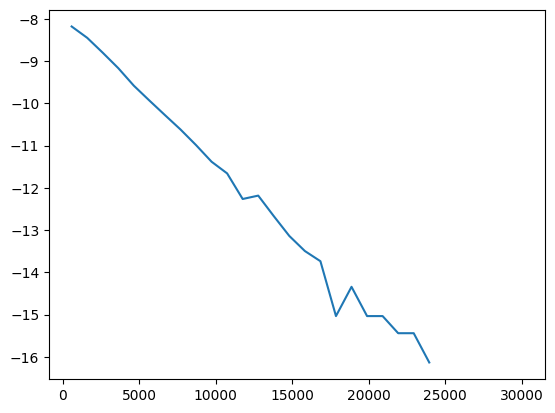

In [39]:
plt.plot(x,np.log(y))

In [ ]:
rs = np.linspace(0, 0.5, 20)
fp = []
for r in rs:
    fpt = fpt_dist(1000, 0, r, 10000)
    y,x = np.histogram(fpt, bins = 30, density = True)
    x = (x[:-1] + x[1:]) / 2
    fp.append(get_linreg_stats(x,y)["slope"])

In [ ]:
plt.plot(rs, pf)

# Mean First Passage Time
We study the dependance on the mean first passage time on $N, m_0, r$

In [3]:
Nvals = np.linspace(100,1000, 10)
m0vals = np.linspace(-1,1,21)
rvals = np.linspace(0,0.5, 21)

In [ ]:
for r in [0.01, 0.05, 0.1]:
    yN_sim = []
    yN_th = []
    for N in tqdm(Nvals):
        yN_sim.append(np.mean(fpt_dist(int(N), 0, r, 10000)))
        yN_th.append(fpt.mean_fpt(int(N), 0, r))
    
    yN_sim = np.array(yN_sim)
    yN_th = np.array(yN_th)
    
    plt.figure()
    
    plt.title(f"r = {r}")
    plt.xlabel("N")
    plt.ylabel("MFPT")
    
    plt.scatter(Nvals, yN_sim)
    plt.plot(Nvals, yN_th)
    plt.savefig(f"../figures/first_passage/MFPT_vs_N_r_{r}.pdf")

 60%|█████████████████████████████████████████████████▏                                | 6/10 [40:39<48:26, 726.71s/it]

In [ ]:
ym0_sim = []
ym0_th = []

for m0 in tqdm(m0vals):
    ym0_sim.append(np.mean(fpt_dist(500, m0, 0.1, 10000)))
    ym0_th.append(fpt.mean_fpt(500, m0, 0.1))
    
    ym0_sim = np.array(ym0_sim)
    ym0_th = np.array(ym0_th)

# plt.title(f"r = {r}")
plt.xlabel("m0")
plt.ylabel("MFPT")
    
plt.scatter(m0vals, ym0_sim)
plt.plot(m0vals, ym0_th)
plt.savefig("../figures/first_passage/MFPT_vs_m0.pdf")


# Gillespie Implementation

We try a Gillespie implementation of the simulation to accelerate it. We consider 3 events: resetting, and going up or down in magnetisation. Resetting has a fixed rate $r$ while the changes in magnetisation depend on the magnetisation itself, but we can see that they are equal:

$$ r_- = N\frac{n}{N}\frac{N-n}{N-1} = \frac{n(N-n)}{N-1} \qquad r_+ = N\frac{N-n}{N}\frac{n}{N-1} = \frac{n(N-n)}{N-1} $$

Where $N$ is the total number of nodes and $n$ is the number of nodes of state $+1$

So the total event rate is:

$$ \lambda = r + 2 \frac{n(N-n)}{N-1} $$

In [2]:
@njit
def first_passage_time_gillespie(N, m0, r):
    '''Takes:
    N: number of agents
    r: resetting rate per MC step
    m0: starting magnetisation
    
        Returns:
    t/N: The first passage time to consensus'''
    
    # Initialize
    n = int(N*(m0+1)/2)  
    n_ini = n
    t = 0

    while n*(N-n) != 0:
        la = r/N + 2* ( n*(N-n)/(N-1) )
        t += -np.log(np.random.random())/la

        if np.random.random() < r/N/la:
            n = n_ini
        else:
            if np.random.random() < 0.5:
                n += 1
            else:
                n += -1
        

    return(t)

@njit(parallel=True)
def fpt_dist_gillespie(N, m0, r, samples):
    """
    Returns the first passage time for many samples
    """
    res = np.zeros(samples)
    

    for i in prange(samples):
        res[i] = first_passage_time_gillespie(N, m0, r)
        
    return res

In [3]:
Nvals = np.linspace(100,1000, 10)
m0vals = np.linspace(-1,1,21)
rvals = np.linspace(0,0.5, 21)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.25s/it]


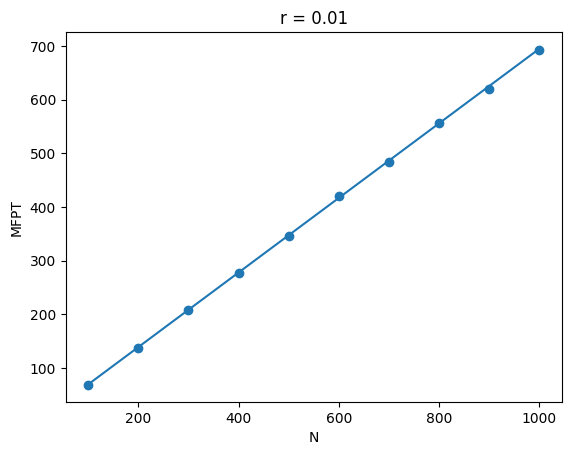

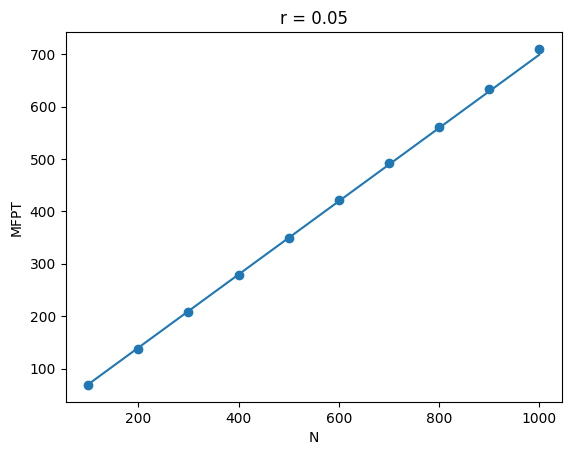

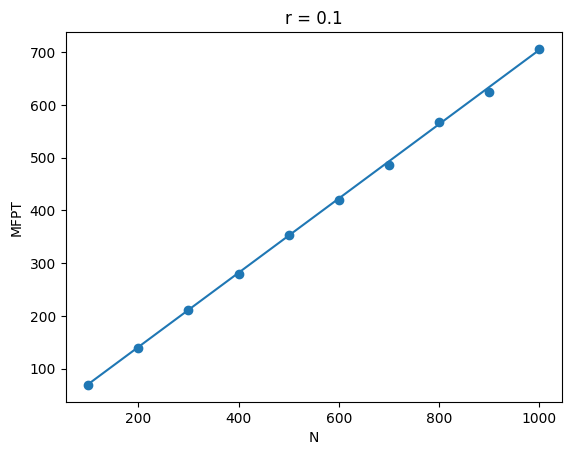

In [4]:
for r in [0.01, 0.05, 0.1]:
    yN_sim = []
    yN_th = []
    for N in tqdm(Nvals):
        yN_sim.append(np.mean(fpt_dist_gillespie(int(N), 0, r, 10000)))
        yN_th.append(fpt.mean_fpt(int(N), 0, r))
    
    yN_sim = np.array(yN_sim)
    yN_th = np.array(yN_th)
    
    plt.figure()
    
    plt.title(f"r = {r}")
    plt.xlabel("N")
    plt.ylabel("MFPT")
    
    plt.scatter(Nvals, yN_sim)
    plt.plot(Nvals, yN_th)
    plt.savefig(f"../figures/first_passage/MFPT_vs_N_r_{r}.pdf")

In [ ]:
ym0_sim = []
ym0_th = []

for m0 in tqdm(m0vals):
    ym0_sim.append(np.mean(fpt_dist_gillespie(500, m0, 0.1, 10000)))
    ym0_th.append(fpt.mean_fpt(500, m0, r))

plt.figure()
plt.title(f"r = {r}")
plt.xlabel("m0")
plt.ylabel("MFPT")
    
plt.scatter(m0vals, ym0_sim)
plt.plot(m0vals, ym0_th)
plt.savefig(f"../figures/first_passage/MFPT_vs_m0_r_{r}.pdf")

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:52<00:00,  5.36s/it]
